# Analysis of a Multi-Zone VAV System at Part-Load
---

In [1]:
from deps import load_packages
load_packages()

In [2]:
import jupyter_addons as ja
ja.set_css()

In this notebook a multi-zone VAV system is analyzed with the package `hvac.air_conditioning`. The example is taken from the book **Heating and Cooling of Buildings** by *T. Agami Reddy, Jan F. Kreider, Peter S. Curtiss and Ari Rabl* (3th Edition, 2017), Chapter 19. For doing the analysis the class `VAVSystem` from the module `hvac.air_conditioning.vav_system.part_load` is used, which resembles the `VAVSystem` class in the `hvac.air_conditioning.vav_system.design` module, that was demonstrated in the previous notebook **Design of a Multi-Zone VAV System (the Shorter Way)**.

In [3]:
from hvac import Quantity
from hvac.fluids import HumidAir
from hvac.air_conditioning.vav_system.part_load import VAVSystem
from hvac.air_conditioning.vav_system import Zone, Season
from hvac.charts import PsychrometricChart, StatePoint

In [4]:
Q_ = Quantity

## Input Data

*Consider the same building with two zones as in **Design of a Multi-Zone VAV System (the Long Way)**  for which a VAV-system was sized. Analyze this system under part-load operation under the following specifications:*

| | Zone A (Exterior Zone) | Zone B (Interior Zone) |
|-|------------------------|------------------------|
| Sensible cooling load | 143,100 Btu/hr | 91,260 Btu/hr |
| Latent cooling load | 36,000 Btu/hr | 20,000 Btu/hr |
| Zone temperature | 75°F | 75°F |

***Given:***
1. Outdoor air conditions: T<sub>db,o</sub> = 77 °F and W<sub>o</sub> = 0.0126 lb<sub>w</sub>/lb<sub>a</sub>.
2. Ventilation air flow rate = 2400.0 ft<sup>3</sup>/min.
3. The design flow rates to each zone: zone A = 780.7 lb<sub>a</sub>/min and zone B = 358.7 lb<sub>a</sub>/min. The supply airflow cannot be reduced to less than 60% of the full-load design value by mass.
4. The supply airflow to the zones cannot be reduced to less than 60% of the full-load design value by mass.
5. Fan efficiency is 60%.

***Assumptions:***
1. The latent load in the interior zone B is unchanged with outdoor temperature.
2. Ignore factors not included in the list given earlier, such as duct heat losses and gains.
3. The location is assumed to be at sea level.
4. Peak loads are coincident; no diversity adjustment is applied.
5. Assume 3 inWG pressure drop in the duct.
6. The preheat coil is inactive.

## Create Zones

### Zone A

In [5]:
zone_A = Zone(
    name='zone A',
    summer=Season(
        Q_sen=Q_(143_100, 'Btu / hr'),
        Q_lat=Q_(36_000, 'Btu / hr'),
        zone_air=HumidAir(Tdb=Q_(75.0, 'degF'), RH=Q_(50, 'pct')),
        m_supply=Q_(780.7, 'lb / min')
    )
)

### Zone B

In [6]:
zone_B = Zone(
    name='zone B',
    summer=Season(
        Q_sen=Q_(91_260, 'Btu / hr'),
        Q_lat=Q_(20_000, 'Btu / hr'),
        zone_air=HumidAir(Tdb=Q_(75.0, 'degF'), RH=Q_(50, 'pct')),
        m_supply=Q_(358.7, 'lb / min')
    )
)

## Create VAV System

**Outdoor Air Condition at Part-Load**

In [7]:
outdoor_air = HumidAir(Tdb=Q_(77, 'degF'), W=Q_(0.0126, 'lb / lb'))

**Volume Flow Rate of Outdoor Ventilation Air**

In [8]:
V_vent = Q_(2400, 'ft ** 3 / min')

**Supply Air Temperature**<br>
In a VAV system the supply air temperature to the zones remains constant and equal to the supply air temperature at design conditions.

In [9]:
T_supply = Q_(55, 'degF')

**Create VAV System**

In [10]:
vav_system = VAVSystem(
    zones=[zone_A, zone_B],
    T_supply=T_supply,
    outdoor_air=outdoor_air,
    V_vent=V_vent
)

## Solve VAV System at Part Load

In [11]:
results = vav_system.part_load_summer(
    supply_fan_efficiency=Q_(60, 'pct'),
    suppy_fan_pressure=Q_(3.0, 'inch_H2O_60F')
)

In [12]:
ja.display_list(
    vav_system.show_results_markdown(
        results,
        units={
            'Q': ('Btu / hr', 0),
            'V': ('ft ** 3 / min', 0),
            'K': ('degF', 1)
        }
    )
)

### Psychrometric Chart

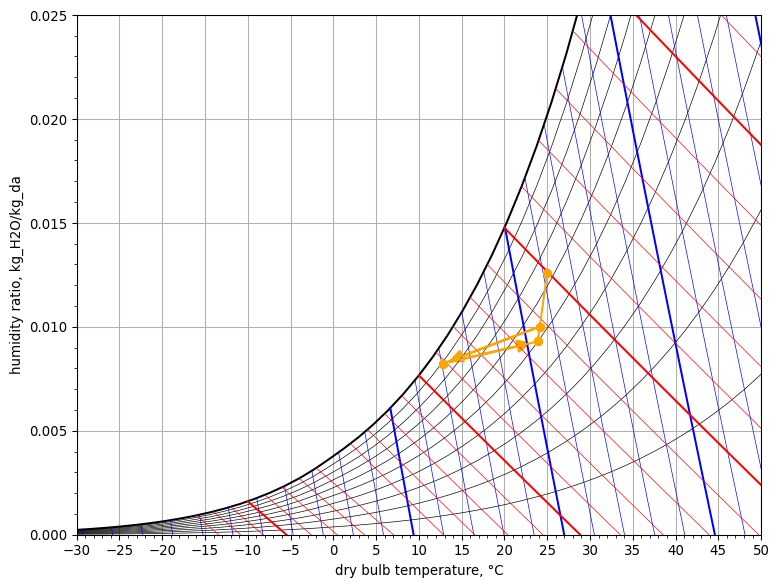

In [13]:
chart = PsychrometricChart(fig_size=(8, 6))
chart.plot_process(
    'mixing_chamber',
    StatePoint(vav_system.summer.outdoor_air.Tdb, vav_system.summer.outdoor_air.W),
    StatePoint(vav_system.summer.return_air.Tdb, vav_system.summer.return_air.W),
    StatePoint(vav_system.summer.mixed_air.Tdb, vav_system.summer.mixed_air.W)
)
chart.plot_process(
    'cooling coil',
    StatePoint(vav_system.summer.mixed_air.Tdb, vav_system.summer.mixed_air.W),
    StatePoint(vav_system.summer.cooled_air.Tdb, vav_system.summer.cooled_air.W)
)
# chart.plot_process(
#     'supply fan',
#     StatePoint(vav_system.summer.cooled_air.Tdb, vav_system.summer.cooled_air.W),
#     StatePoint(vav_system.summer.supply_air.Tdb, vav_system.summer.supply_air.W)
# )
chart.plot_process(
    'zones',
    StatePoint(vav_system.summer.supply_air.Tdb, vav_system.summer.supply_air.W),
    StatePoint(vav_system.summer.return_air.Tdb, vav_system.summer.return_air.W)
)
chart.show()

### Zone Info

In [14]:
ja.display_list([
    f"return air at {zone.name}: <b>{zone.summer.return_air.Tdb.to('degF'):~P.1f} TDB, "
    f"{zone.summer.return_air.RH.to('pct'):~P.0f} RH</b>, "
    f"supply air volume flow rate: <b>{zone.summer.V_supply.to('ft ** 3 / min'):~P.0f}</b>"
    for zone in vav_system.zones
])